In [30]:
import simexpal
import pandas as pd
import yaml
import numpy as np
from matplotlib import pyplot as plt
import networkit as nk
from statistics import geometric_mean

In [2]:
def parse(run, f):
    output = yaml.load(f, Loader=yaml.Loader)
    exp = output['Runs'][0]
    if 'Results' in exp:
        res = []
        # exp['Result'] = [{Focus Node, Value, Gain, Time, Original Value, AddedEdgeList},...]
        algo_name = run.experiment.name
        if '_single' in algo_name:
            algo_name = algo_name[:-7]
        if 'Dyn' in algo_name:
            algo_name = algo_name[:-3]
        variants = [run.experiment.variation[i].name for i in range(len(run.experiment.variation))]
        if variants.count('focus-50') > 0:
            num_focus_nodes = 50
        elif variants.count('focus-100') > 0:
            num_focus_nodes = 100
        elif variants.count('focus-25') > 0:
            num_focus_nodes = 25
        else:
            num_focus_nodes = None
        
        for result in exp['Results']:
            single_res = {
                'Experiment': algo_name + 'JLT' if 'Linalg' in exp and 'JLT' in exp['Linalg'] else algo_name,
                'Instance': run.instance.shortname,
                'Revision': run.experiment.revision.name,
                'k': exp['k'] or None,
                'Linalg': exp['Linalg'] if 'Linalg' in exp else None,
                'Algorithm': exp['Algorithm'] if 'Algorithm' in exp else None,
                'InitTime': exp['InitTime'] if 'InitTime' in exp else None,
                'Focus Node': result['Focus Node'] if 'Focus Node' in result else None,
                '#Focus Nodes': num_focus_nodes,
                'Gain': result['Gain'] if 'Gain' in result else None,
                'Time': result['Time'] if 'Time' in result else None,
                'Reset Time': result['Reset Time'] if 'Reset Time' in result else None,
                'status': str(run.get_status()),
            }
            res.append(single_res)
    return res

In [3]:
size_ordered = [
    'inf-power',
    'facebook_ego_combined',
    'web-spam',
    'wiki-Vote',
    'p2p-Gnutella09',
    'p2p-Gnutella04',
    'web-indochina-2004',
    'arxiv-heph',
    'web-webbase-2001',
    'arxiv-astro-ph',
    'as-caida20071105',
    'cit-HepTh',
    'ia-email-EU',
]
#'orange', 'royalblue', 'magenta', 'lightgreen','darkgreen' , 'gold', 'plum'
colormap = {
    'simplStoch': 'orange',
    'simplStochJLT': 'royalblue',
    'colStoch': 'magenta',
    'colStochJLT': 'lightgreen',
    'specStoch': 'darkgreen',
    'stGreedy': 'plum',
}

In [4]:
cfg = simexpal.config_for_dir()
results = []

for run in cfg.discover_all_runs():
    if run.experiment.revision.name == 'local-addition-v3' and 'medium-graphs' in run.instance.instsets:
        with run.open_output_file() as f:
            for res in parse(run, f):
                results.append(res)

results = pd.DataFrame(results)

In [5]:
# add amortized time
results['Amortized Time'] = results['Time'] + results['InitTime'] / results['#Focus Nodes']

In [6]:
# sort by experiment (pandas uses this ordering when sorting the bars in bar plots) for consistency with GRIP plots
results['Experiment'] = pd.Categorical(results['Experiment'], ['simplStoch', 'simplStochJLT', 'colStoch', 'colStochJLT', 'specStoch', 'stGreedy'])
results['k'] = pd.Categorical(results['k'], [2, 5, 20])
results.sort_values('Experiment', inplace=True)
results

,Experiment,Instance,Revision,k,Linalg,Algorithm,InitTime,Focus Node,#Focus Nodes,Gain,Time,Reset Time,status,Combined Time
2871,simplStoch,arxiv-astro-ph,local-addition-v3,2,None,simplStoch,1158.8400,4397,25,541203.0,0.883468,0.394166,finished,47.237068
3197,simplStoch,arxiv-astro-ph,local-addition-v3,20,None,simplStoch,1159.8800,4822,25,1468910.0,5.170540,0.400727,finished,51.565740
3196,simplStoch,arxiv-astro-ph,local-addition-v3,20,None,simplStoch,1159.8800,4397,25,1534000.0,5.170470,0.400646,finished,51.565670
3195,simplStoch,arxiv-astro-ph,local-addition-v3,20,None,simplStoch,1159.8800,4161,25,1503280.0,5.170300,0.400527,finished,51.565500
3194,simplStoch,arxiv-astro-ph,local-addition-v3,20,None,simplStoch,1159.8800,3330,25,1439020.0,5.168310,0.400708,finished,51.563510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,stGreedy,arxiv-astro-ph,local-addition-v3,20,None,stGreedy,1158.3100,3330,25,2098060.0,5.114710,0.387385,finished,51.447110
4993,stGreedy,arxiv-astro-ph,local-addition-v3,20,None,stGreedy,1158.3100,4161,25,2152430.0,5.117590,0.387441,finished,51.449990
4994,stGreedy,arxiv-astro-ph,local-addition-v3,20,None,stGreedy,1158.3100,4397,25,2168440.0,5.115870,0.387516,finished,51.448270
4996,stGreedy,arxiv-astro-ph,local-addition-v3,20,None,stGreedy,1158.3100,4978,25,2139390.0,5.114120,0.387396,finished,51.446520


In [7]:
# relative speedup and quality compared to stGreedy
def normalize_group(group):
    if 'stGreedy' in group['Experiment'].unique():
        group['Relative Speedup'] = float(group.loc[group['Experiment'] == 'stGreedy']['Amortized Time']) / group['Amortized Time']
        group['Relative Quality'] = group['Gain'] / float(group.loc[group['Experiment'] == 'stGreedy']['Gain'])
        return group.loc[group['Experiment'] != 'stGreedy'][['Experiment', 'Relative Speedup', 'Relative Quality']]

normalized_results = results.loc[(results['status'] == 'finished')].groupby(['k', 'Instance', 'Focus Node'], group_keys=True).apply(lambda group: normalize_group(group))
normalized_results = normalized_results.reset_index(['k', 'Instance', 'Focus Node'])
normalized_results

,k,Instance,Focus Node,Experiment,Relative Speedup,Relative Quality
2865,2,arxiv-astro-ph,6,simplStoch,1.009428,0.976729
1901,2,arxiv-astro-ph,6,simplStochJLT,0.367020,0.943515
0,2,arxiv-astro-ph,6,colStoch,0.154791,1.000000
936,2,arxiv-astro-ph,6,colStochJLT,0.377428,0.933030
3840,2,arxiv-astro-ph,6,specStoch,0.108987,0.014019
...,...,...,...,...,...,...
3514,20,wiki-Vote,7062,simplStoch,1.006372,0.493783
2542,20,wiki-Vote,7062,simplStochJLT,0.227846,0.469919
623,20,wiki-Vote,7062,colStoch,0.251769,0.728122
1577,20,wiki-Vote,7062,colStochJLT,0.218208,0.611252


<Axes: xlabel='Instance', ylabel='Time (s)'>

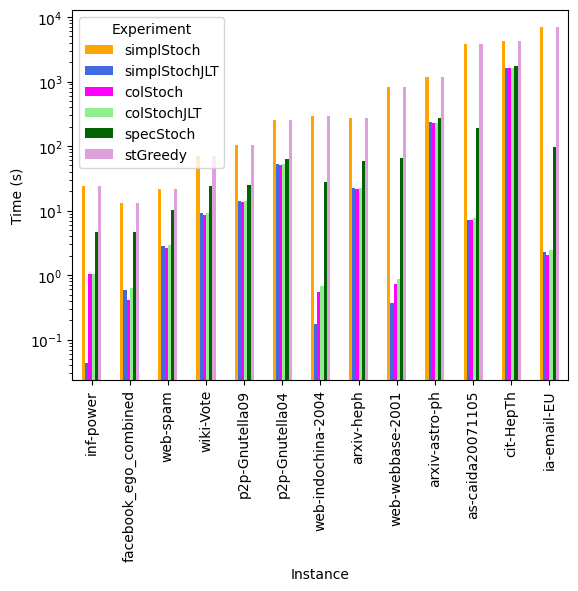

In [8]:
# plot preprocessing time
results.pivot_table(values='InitTime', index='Instance', columns='Experiment').loc[size_ordered].plot(kind='bar', logy=True, title='', ylabel='Time (s)', color=colormap)

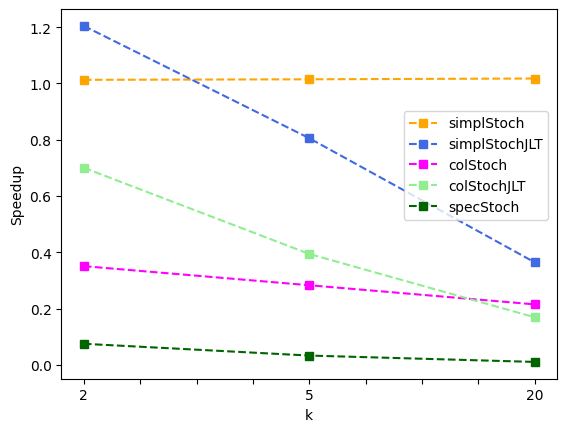

In [50]:
# 

normalized_results.loc[(normalized_results['Instance'].isin(small_graphs))].pivot_table(values='Relative Speedup', index='k', columns='Experiment', aggfunc=geometric_mean).plot(kind='line', ylabel='Speedup', title='', linestyle='--', marker='s', color=colormap)
plt.legend(loc=(0.69,0.43))

In [51]:
normalized_results.loc[(normalized_results['Instance'].isin(small_graphs))].pivot_table(values='Relative Speedup', index='k', columns='Experiment', aggfunc=geometric_mean)

Experiment,simplStoch,simplStochJLT,colStoch,colStochJLT,specStoch
k,,,,,
2,1.012781,1.204305,0.350947,0.700360,0.075097
5,1.014675,0.805341,0.283080,0.394238,0.033246
20,1.017443,0.364355,0.215072,0.169207,0.010662


<Axes: xlabel='k', ylabel='Speedup'>

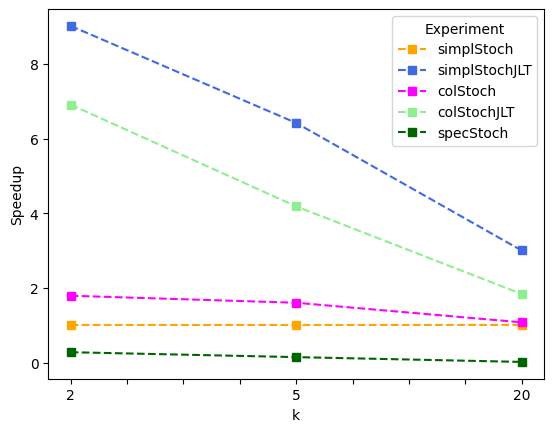

In [39]:
# 
normalized_results.loc[(normalized_results['Instance'].isin(medium_graphs))].pivot_table(values='Relative Speedup', index='k', columns='Experiment', aggfunc=geometric_mean).plot(kind='line', ylabel='Speedup', title='', linestyle='--', marker='s', color=colormap)

In [52]:
normalized_results.loc[(normalized_results['Instance'].isin(medium_graphs))].pivot_table(values='Relative Speedup', index='k', columns='Experiment', aggfunc=geometric_mean)

Experiment,simplStoch,simplStochJLT,colStoch,colStochJLT,specStoch
k,,,,,
2,1.005711,9.019683,1.789052,6.908846,0.275940
5,1.004426,6.419241,1.601381,4.183974,0.144546
20,1.007388,3.002071,1.076599,1.836555,0.015610


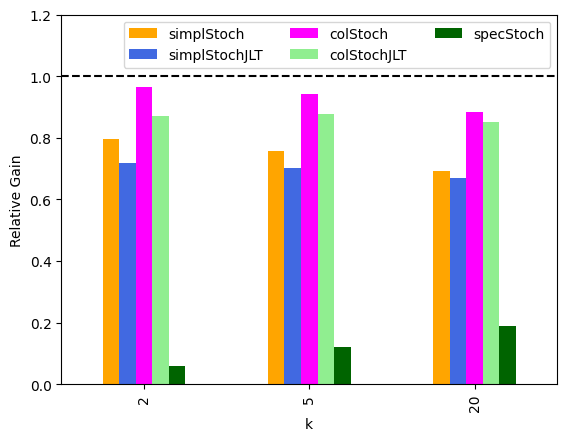

In [34]:
# 
normalized_results.pivot_table(values='Relative Quality', index='k', columns='Experiment', aggfunc=geometric_mean).plot(kind='bar', ylabel='Relative Gain', title='', color=colormap, ylim=(0,1.2))
plt.legend(ncol=3)
plt.axhline(y=1, linestyle='--', color='black')

In [57]:
small_graphs = [
    'inf-power',
    'facebook_ego_combined',
    'web-spam',
    'wiki-Vote',
    'p2p-Gnutella09',
]

medium_graphs = [
    'p2p-Gnutella04',
    'web-indochina-2004'
    'arxiv-heph',
    'web-webbase-2001',
    'arxiv-astro-ph',
    'as-caida20071105',
    'cit-HepTh',
    'ia-email-EU'
]

<Axes: xlabel='k', ylabel='Time (s)'>

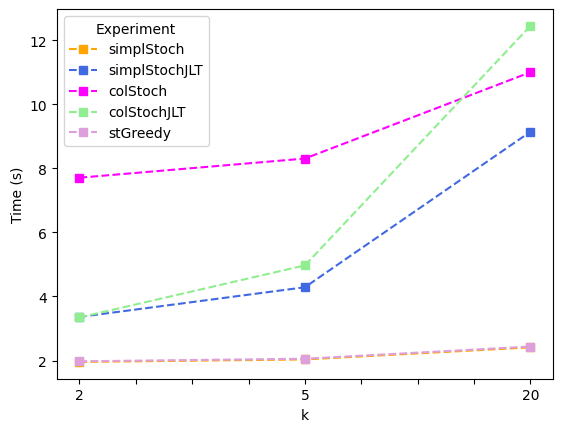

In [58]:
small_pvt = results.loc[(results['Instance'].isin(small_graphs)) & (results['Experiment'] != 'specStoch') & (results['status'] == 'finished')].pivot_table(values='Amortized Time', index='k', columns='Experiment')
small_pvt.plot(kind='line', ylabel='Time (s)', title='', linestyle='--', marker='s', color=colormap)
# plt.legend(loc=(1.01,.35))

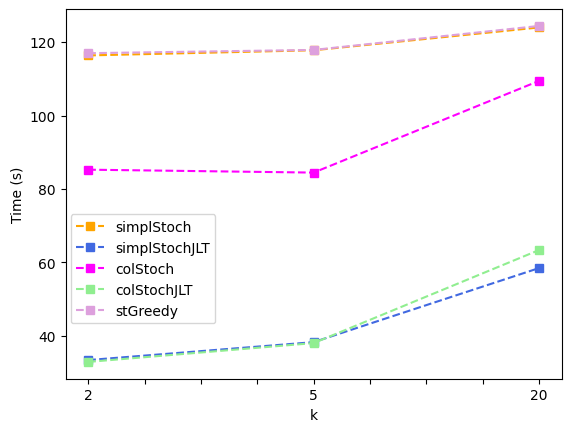

In [59]:
med_pvt = results.loc[(results['Instance'].isin(medium_graphs)) & (results['Experiment'] != 'specStoch') & (results['status'] == 'finished')].pivot_table(values='Amortized Time', index='k', columns='Experiment')
med_pvt.plot(kind='line', ylabel='Time (s)', title='', linestyle='--', marker='s', color=colormap)
plt.legend(loc=(0.01,.15))

In [35]:
normalized_results.pivot_table(values='Relative Quality', index='k', columns='Experiment', aggfunc=geometric_mean)

Experiment,simplStoch,simplStochJLT,colStoch,colStochJLT,specStoch
k,,,,,
2,0.797090,0.717665,0.963633,0.870413,0.059971
5,0.757199,0.703462,0.942522,0.876436,0.121705
20,0.690755,0.670780,0.885263,0.850527,0.188210


In [36]:
normalized_results.pivot_table(values='Relative Speedup', index='k', columns='Experiment', aggfunc=geometric_mean)

Experiment,simplStoch,simplStochJLT,colStoch,colStochJLT,specStoch
k,,,,,
2,1.007797,3.667752,0.879136,2.300567,0.143432
5,1.008819,2.473312,0.725920,1.324933,0.058027
20,1.012031,1.111961,0.471014,0.568726,0.012746


In [365]:
kgrip_instance_map = {
    # kgrip code name, paper name
    'Wiki-Vote': 'wiki-Vote',
    'arxiv-astro-ph': 'arxiv-astro-ph',
    'as-caida20071105': 'as-caida20071105', 
    'ca-HepPh': 'arxiv-heph',
    'cit-HepTh': 'cit-HepTh',
    'facebook_ego_combined': 'facebook_ego_combined',
    'ia-email-EU': 'ia-email-EU',
    'inf-power': 'inf-power',
    'p2p-Gnutella04': 'p2p-Gnutella04',
    'p2p-Gnutella09': 'p2p-Gnutella09',
    'web-indochina-2004': 'web-indochina-2004',
    'web-spam': 'web-spam',
    'web-webbase-2001': 'web-webbase-2001',
}

kgrip_experiment_map = {
    # kgrip experiment name, lrip/paper name
    'sq-greedy': 'colStoch',  # a6
    'stochastic-greedy': 'simplStoch',  # a2
    'stochastic-greedy-dyn': 'simplStochJLT',   # a3
    'stochastic-spectral': 'specStoch',  #a7
    'submodular-greedy': 'stGreedy',   #a1
}

def parse_kgrip(run, f):
    # map instance names
    if run.instance.shortname in kgrip_instance_map:
        instance = kgrip_instance_map[run.instance.shortname]
    else: # skip reading results for other instances
        return []
    
    # map algorithm names
    if run.experiment.name in kgrip_experiment_map:
        algo_name = kgrip_experiment_map[run.experiment.name]
    else:
        return []
    
    
    # Get all used parameter
    var_dict = dict()
    for var in run.experiment.variation:
        var_dict[var.axis] = var.name
    # skip eps_0.99
    if 'accuracy' in var_dict and var_dict['accuracy'] != 'eps_0.9':
        return []
    # skip other spectral objective computations
    if algo_name == 'specStoch' and ('objective' not in var_dict or var_dict['objective'] != 'mid2'):
        return []
    
    output = yaml.load(f, Loader=yaml.Loader)
    exp = output['Runs'][0]
        
    res = {
        'Experiment': algo_name + 'JLT' if 'Linalg' in exp and 'JLT' in exp['Linalg'] and algo_name == 'colStoch' else algo_name,
        'Instance': instance,
        'k': exp['k'] if 'k' in exp else None,
        'Linalg': exp['Linalg'] if 'Linalg' in exp else None,
        'Algorithm': exp['Algorithm'] if 'Algorithm' in exp else None,
        'Gain': exp['Gain'] if 'Gain' in exp else None,
        'Time': exp['Time'] if 'Time' in exp else None,
    }
    
    return [res]

cfg_kgrip = simexpal.config_for_dir('/work/predarim/ESA22/experiments_comparison')
results_kgrip = []

for run_kgrip in cfg_kgrip.discover_all_runs():
    # print(run_kgrip.experiment.display_name)
    try:
        with run_kgrip.open_output_file() as f:
            for res in parse_kgrip(run_kgrip, f):
                results_kgrip.append(res)
    except:
        print(run_kgrip.experiment.display_name, run_kgrip.instance.shortname)
        

results_kgrip = pd.DataFrame(results_kgrip)

In [366]:
results_kgrip['Experiment'] = pd.Categorical(results_kgrip['Experiment'], ['simplStoch', 'simplStochJLT', 'colStoch', 'colStochJLT', 'specStoch', 'stGreedy'])
results_kgrip['k'] = pd.Categorical(results_kgrip['k'], [2, 5, 20, 50, 100])
results_kgrip = results_kgrip.loc[results_kgrip['Linalg'].isin((None,'LU','JLT via Sparse LU'))]
results_kgrip.sort_values('Experiment', inplace=True)
# results_kgrip = results_kgrip.loc[results_kgrip['k'].isin((2,5,20))] # remove k=50,100
results_kgrip

,Experiment,Instance,k,Linalg,Algorithm,Gain,Time
584,simplStoch,web-webbase-2001,50,None,Stochastic,573812000.0,1668.510
555,simplStoch,p2p-Gnutella09,20,None,Stochastic,348066.0,135.812
556,simplStoch,web-indochina-2004,20,None,Stochastic,16215900.0,518.863
557,simplStoch,web-spam,20,None,Stochastic,419899.0,29.104
558,simplStoch,web-webbase-2001,20,None,Stochastic,541214000.0,1428.030
...,...,...,...,...,...,...,...
807,stGreedy,arxiv-astro-ph,20,None,Submodular,2305200.0,5137.570
808,stGreedy,as-caida20071105,20,None,Submodular,3470520.0,18292.900
809,stGreedy,arxiv-heph,20,None,Submodular,1272960.0,1333.750
794,stGreedy,arxiv-astro-ph,2,None,Submodular,582999.0,5628.270


In [367]:
# relative speedup and quality compared to stGreedy
def normalize_group_kgrip(group):
    if 'stGreedy' in group['Experiment'].unique():
        group['Relative Speedup'] = float(group.loc[group['Experiment'] == 'stGreedy']['Time']) / group['Time']
        group['Relative Quality'] = group['Gain'] / float(group.loc[group['Experiment'] == 'stGreedy']['Gain'])
        return group.loc[group['Experiment'] != 'stGreedy'][['Experiment', 'Relative Speedup', 'Relative Quality']]

normalized_results_kgrip = results_kgrip.groupby(['k', 'Instance'], group_keys=True).apply(lambda group: normalize_group_kgrip(group))
normalized_results_kgrip = normalized_results_kgrip.reset_index(['k', 'Instance'])
normalized_results_kgrip

,k,Instance,Experiment,Relative Speedup,Relative Quality
534,2,arxiv-astro-ph,simplStoch,3.317538,0.986535
664,2,arxiv-astro-ph,simplStochJLT,33.818047,0.844516
14,2,arxiv-astro-ph,colStoch,3.946783,0.999901
339,2,arxiv-astro-ph,colStochJLT,41.566804,0.772739
725,2,arxiv-astro-ph,specStoch,34.023709,0.842214
...,...,...,...,...,...
520,100,wiki-Vote,simplStoch,3.533151,0.990840
650,100,wiki-Vote,simplStochJLT,9.518555,0.907102
0,100,wiki-Vote,colStoch,3.512317,0.997582
325,100,wiki-Vote,colStochJLT,8.509758,0.915049


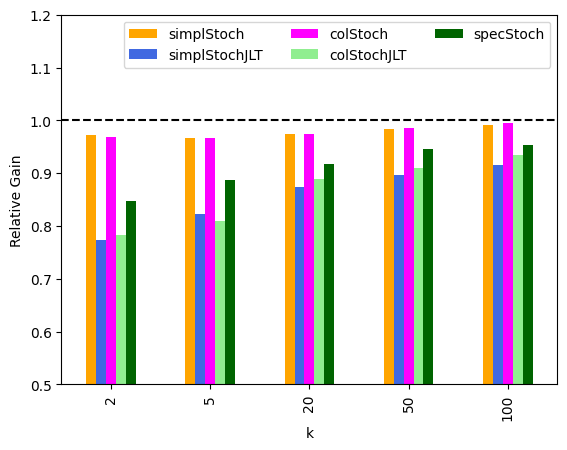

In [368]:
normalized_results_kgrip.pivot_table(values='Relative Quality', index='k', columns='Experiment', aggfunc=geometric_mean).plot(kind='bar', ylabel='Relative Gain', title='', color=colormap, ylim=(0.5,1.2))
plt.legend(ncol=3)
plt.axhline(y=1, linestyle='--', color='black')

In [413]:
lrip_gain = results.groupby(['k','Experiment','Instance'],group_keys=True)['Gain'].mean().reset_index()

In [414]:
grip_gain = results_kgrip.loc[results_kgrip['k'].isin((2,5,20))][['Experiment','Instance','k','Gain']]

In [415]:
# lrip_gain.rename(columns={'Gain': 'LRIP Gain'},inplace=True)
lrip_gain = lrip_gain.set_index(['k','Experiment','Instance'])
lrip_gain

Gain
k  Experiment Instance                           
2  simplStoch arxiv-astro-ph         4.651375e+05
              arxiv-heph             2.160903e+05
              as-caida20071105       6.358459e+05
              cit-HepTh              4.171754e+05
              facebook_ego_combined  8.950155e+04
...                                           ...
20 stGreedy   p2p-Gnutella09         3.261254e+05
              web-indochina-2004     1.308099e+07
              web-spam               4.071293e+05
              web-webbase-2001       5.078421e+08
              wiki-Vote              2.048616e+05

[234 rows x 1 columns]

In [416]:
# grip_gain.rename(columns={'Gain': 'GRIP Gain'},inplace=True)
grip_gain = grip_gain.set_index(['k','Experiment','Instance'])
grip_gain

Gain
k  Experiment Instance                       
20 simplStoch p2p-Gnutella09         348066.0
              web-indochina-2004   16215900.0
              web-spam               419899.0
              web-webbase-2001    541214000.0
5  simplStoch wiki-Vote               76063.5
...                                       ...
20 stGreedy   wiki-Vote              216836.0
              arxiv-astro-ph        2305200.0
              as-caida20071105      3470520.0
              arxiv-heph            1272960.0
2  stGreedy   arxiv-astro-ph         582999.0

[234 rows x 1 columns]

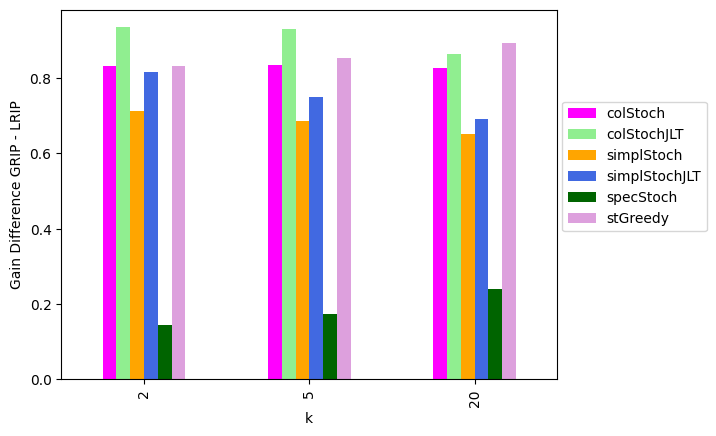

In [458]:
(lrip_gain / grip_gain).reset_index().rename(columns={'Gain': 'Gain Difference'}).pivot_table(values='Gain Difference', index='k', columns='Experiment').plot(kind='bar', ylabel='Gain Difference GRIP - LRIP', title='', color=colormap)
plt.legend(loc=(1.01,0.4))

<Axes: ylabel='Frequency'>

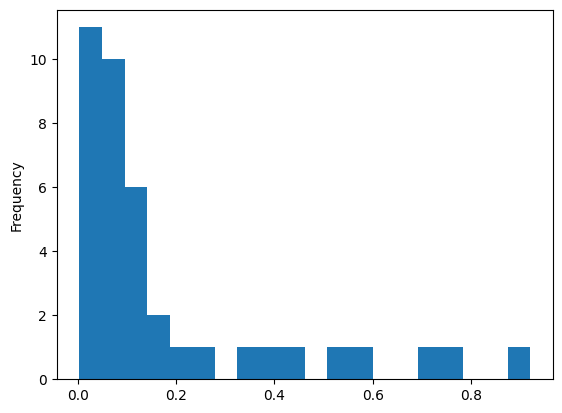

In [459]:
relgain = (lrip_gain / grip_gain).reset_index()
relgain.loc[relgain['Experiment'] == 'specStoch']['Gain'].plot(kind='hist', bins=20)

In [432]:
(lrip_gain / grip_gain).std()

Gain    0.278266
dtype: float64

In [494]:
print(np.round(results_kgrip.loc[results_kgrip['k'] == 2].pivot_table(values='Time', index='Experiment', columns='Instance'), decimals=1).T.loc[size_ordered].to_latex())

\begin{tabular}{lrrrrrr}
\toprule
Experiment &  simplStoch &  simplStochJLT &  colStoch &  colStochJLT &  specStoch &  stGreedy \\
Instance              &             &                &           &              &            &           \\
\midrule
inf-power             &        50.0 &            1.6 &      10.1 &          3.2 &        4.0 &     118.3 \\
facebook\_ego\_combined &        18.6 &            1.7 &       5.8 &          0.7 &        4.1 &      46.0 \\
web-spam              &        29.2 &            3.4 &      17.8 &          1.8 &        5.6 &      68.5 \\
wiki-Vote             &       110.1 &            9.0 &      65.7 &          5.4 &       12.7 &     357.6 \\
p2p-Gnutella09        &       137.3 &           13.0 &      94.6 &          8.1 &       16.3 &     296.0 \\
p2p-Gnutella04        &       452.5 &           38.2 &     297.0 &         28.1 &       40.1 &    1163.2 \\
web-indochina-2004    &       489.6 &           10.6 &      95.9 &          1.9 &       15.2 &    1700

/tmp/ipykernel_877825/3947119350.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(np.round(results_kgrip.loc[results_kgrip['k'] == 2].pivot_table(values='Time', index='Experiment', columns='Instance'), decimals=1).T.loc[size_ordered].to_latex())


In [495]:
print(np.round(results_kgrip.loc[results_kgrip['k'] == 100].pivot_table(values='Time', index='Experiment', columns='Instance'), decimals=1).T.loc[size_ordered].to_latex())

\begin{tabular}{lrrrrrr}
\toprule
Experiment &  simplStoch &  simplStochJLT &  colStoch &  colStochJLT &  specStoch &  stGreedy \\
Instance              &             &                &           &              &            &           \\
\midrule
inf-power             &        41.5 &            3.4 &     125.3 &        140.1 &       63.6 &     594.6 \\
facebook\_ego\_combined &        19.9 &           14.3 &      19.1 &         23.5 &       56.6 &     139.3 \\
web-spam              &        31.0 &           18.3 &      50.8 &         32.5 &       80.2 &      79.3 \\
wiki-Vote             &       121.4 &           45.1 &     122.1 &         50.4 &      133.0 &     428.9 \\
p2p-Gnutella09        &       141.3 &           51.5 &     173.7 &         54.7 &      114.5 &     314.3 \\
p2p-Gnutella04        &       448.2 &          129.3 &     580.5 &        133.7 &      164.6 &    1298.2 \\
web-indochina-2004    &       512.6 &           18.3 &     137.8 &         73.6 &      161.1 &    3524

/tmp/ipykernel_877825/2407129973.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(np.round(results_kgrip.loc[results_kgrip['k'] == 100].pivot_table(values='Time', index='Experiment', columns='Instance'), decimals=1).T.loc[size_ordered].to_latex())
